In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [152]:
df = pd.read_csv(r"C:\Users\Jiang\Documents\Mie_Py\Mie_Postprocessing_Py\BC20241003_HZ_Nozzle1\T1\1.csv")

In [153]:
or_ = 384
ir_ = 11

# or_ = 90mm

mm_per_px_scale = 90.0/or_

print(f"mm per pixel: {mm_per_px_scale}")

mm per pixel: 0.234375


In [154]:
tilt_ang = (180.0-df["umbrella_angle_deg"][0].item())/2.0

umbrella_angle_correction = 1.0/np.cos(tilt_ang * (np.pi / 180.0))

pen_correction = mm_per_px_scale * umbrella_angle_correction

print(f"Penetration multiplier: {pen_correction}")


Penetration multiplier: 0.2494166654240419


In [155]:
df.columns

Index(['frame_idx', 'plumes', 'diameter_mm', 'umbrella_angle_deg', 'fps',
       'chamber_pressure_bar', 'injection_duration_us',
       'penetration_highpass_bw_plume_0', 'penetration_highpass_bw_plume_1',
       'penetration_highpass_bw_plume_2', 'penetration_highpass_bw_plume_3',
       'penetration_highpass_bw_plume_4', 'penetration_highpass_bw_plume_5',
       'penetration_highpass_bw_plume_6', 'penetration_highpass_bw_plume_7',
       'penetration_highpass_bw_plume_8', 'penetration_highpass_bw_plume_9'],
      dtype='object')

In [156]:
df["injection_duration_us"][0].item() * 1e-3

0.56

In [157]:
fps = df["fps"][0].item()

frame_idx = np.asarray(df["frame_idx"])

time_s = frame_idx * 1.0 / fps

time_ms = time_s * 1e3

In [158]:
frame_idx.max() 

np.int64(79)

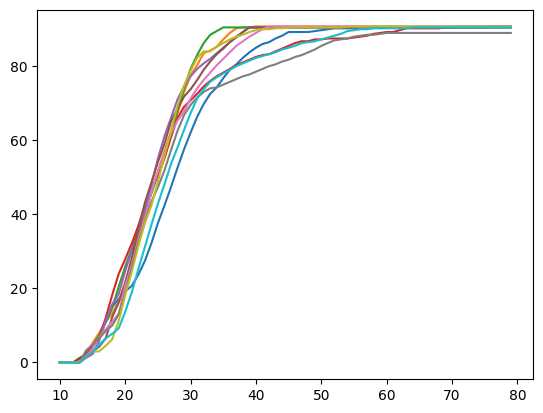

In [159]:
for i in range(10):
    plt.plot(pen_correction*df[f'penetration_highpass_bw_plume_{i}'][10:])

In [160]:
def penetration_cleaning(arr, scaling_factor, diff_threshold=1.0, hd_upper_lim=15):
    penetration_delay = 0

    for f in range(hd_upper_lim):
        if arr[f +1 ] == 0 or np.isnan(arr[f+1]):
            penetration_delay += 1
            arr[f] = np.nan

    arr = np.roll(arr, - penetration_delay)

    arr_diff = np.diff(arr)

    idx = np.where(arr_diff < diff_threshold)[0][0].item()

    arr = arr[:idx]

    arr *= scaling_factor

    return arr, penetration_delay



In [161]:
diff_threshold = 1 # px

number_of_plumes = df["plumes"][0]

cleaned_series = np.zeros((number_of_plumes, frame_idx.max()+1))
delays = np.zeros(( number_of_plumes) )

for i in range(number_of_plumes):

    arr = df[f'penetration_highpass_bw_plume_{i}'].copy()

    cleaned_serie, delay = penetration_cleaning(arr, pen_correction, diff_threshold=diff_threshold)

    delays[i] = delay
    
    cleaned_series[i, :len(cleaned_serie)] = cleaned_serie

    cleaned_series[i, len(cleaned_serie):] = np.nan

In [162]:
inj_dur_ms = df["injection_duration_us"][0]/1e3

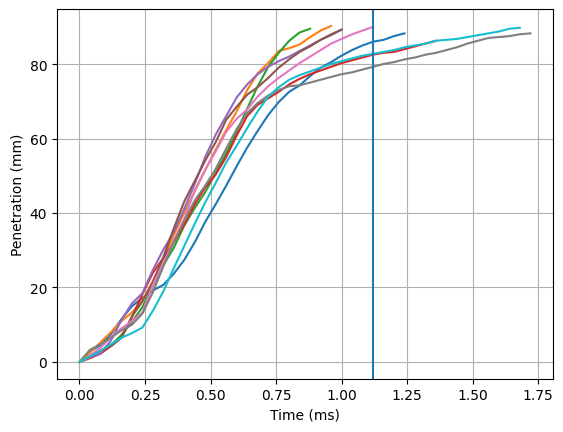

In [163]:
plt.plot(time_ms, cleaned_series.T)
# plt.axvline(inj_dur_ms)
plt.axvline(2*inj_dur_ms)
plt.ylabel("Penetration (mm)")
plt.xlabel("Time (ms)")
plt.grid()

In [165]:
frame_idx_at_2ti =  round(2*inj_dur_ms * 1e-3 * fps)

not_saturated = cleaned_series[:, frame_idx_at_2ti] < np.nanmax(cleaned_series, axis=1)

In [166]:
not_saturated

array([ True, False, False,  True, False, False, False,  True, False,
        True])